<a href="https://colab.research.google.com/github/Fellipe0/Hill-Chart-Comparation/blob/main/Feed_forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from tensorflow import keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import math

def normalize(array):
  return [(array[n] - min(array)) / (max(array) - min(array)) for n in range(len(array))]

def load_dataset():
  # Função de carregamento dos dados da tabela
  def load_spreadsheet():
    input = []
    output = []

    caminho_ate_arquivo = '/content/drive/MyDrive/Faculdade/IC/Felipe Libório/Artigos/Algoritmo/Dados Sensores.xlsx'
    train_dataset = pd.read_excel(caminho_ate_arquivo)
    size = len(list(train_dataset['Queda']))

    queda = normalize(list(train_dataset['Queda']))
    vazao = normalize(list(train_dataset['Vazao']))
    eficiencia = normalize(list(train_dataset['Rendimento']))
    potencia = normalize(list(train_dataset['Potencia']))
    percentual = normalize(list(train_dataset['DistribuidorD']))
    angulo = normalize(list(train_dataset['RotorD']))

    for i in range(size):
      input.append( [queda[i],vazao[i]] )
      output.append( [eficiencia[i],potencia[i],percentual[i],angulo[i]] )

    return input,output

  data,target = load_spreadsheet()

  data = np.array(data, dtype=float)
  target = np.array(target, dtype=float)

  return train_test_split(data,target,test_size=0.2,random_state=5)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
# Calcular e printar resultados
def calculateAndPrintEfficience(obtido,real):
  # Calculo de erros
  def mean_absolute_error(predict,expected):
    qtd = len(predict)
    valor = 0
    for n in range(qtd):
      valor += abs(predict[n] - expected[n])
    out = valor/qtd
    return out

  def mean_squared_error(predict,expected):
    qtd = len(predict)
    valor = 0
    for n in range(qtd):
      valor += (predict[n] - expected[n])**2
    out = valor/qtd
    return math.sqrt(out)

  mae_1 = mean_absolute_error(obtido[:,0],real[:,0]);
  mae_2 = mean_absolute_error(obtido[:,1],real[:,1]);
  mae_3 = mean_absolute_error(obtido[:,2],real[:,2]);
  mae_4 = mean_absolute_error(obtido[:,3],real[:,3]);

  rmse_1 = mean_squared_error(obtido[:,0],real[:,0]);
  rmse_2 = mean_squared_error(obtido[:,1],real[:,1]);
  rmse_3 = mean_squared_error(obtido[:,2],real[:,2]);
  rmse_4 = mean_squared_error(obtido[:,3],real[:,3]);

#R² sempre colocar (original, predito)
  r2_1 = r2_score(obtido[:,0],real[:,0]);
  r2_2 = r2_score(obtido[:,1],real[:,1]);
  r2_3 = r2_score(obtido[:,2],real[:,2]);
  r2_4 = r2_score(obtido[:,3],real[:,3]);

  # Metodo de realizar o print
  def printMethod(title,data):
    format_row = "{:>12}" * (len(title) + 1);

    print(format_row.format(" ",*title));
    for element in data:
      print(format_row.format(*element));

  titlePrint = ["Eficiência", "Potência","Percentual","Ângulo"];
  dataPrint = [["RMSE", "{:.4f}".format(rmse_1) , "{:.4f}".format(rmse_2) , "{:.4f}".format(rmse_3) , "{:.4f}".format(rmse_4)],
              ["MAE", "{:.4f}".format(mae_1) , "{:.4f}".format(mae_2) , "{:.4f}".format(mae_3) , "{:.4f}".format(mae_4)],
              ["R²", "{:.4f}".format(r2_1) , "{:.4f}".format(r2_2) , "{:.4f}".format(r2_3) , "{:.4f}".format(r2_4)]];
  printMethod(titlePrint,dataPrint)

def plot_grafic(y_real,y_predito):
  titlePrint = ["Eficiência", "Potência","Percentual","Ângulo"];
  print("Plot results")
  for n in range(y_real.shape[1]):
    plt.plot(y_real[:,n], 'b-', label="Real")
    plt.plot(y_predito[:,n], 'g--', label="Predito")
    plt.legend()
    plt.ylabel(titlePrint[n]);
    plt.show()

In [ ]:
def struture_model(learning_rate,inputs,targets):
  # Model configuration
  batch_size = 25
  no_epochs = 1000
  num_folds = 10

  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(inputs, targets):

    # Define the model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='tanh', input_shape=(2,)),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(4, activation='sigmoid')
    ])

    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=["accuracy"])

    # Fit data to model
    es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)
    model.fit(inputs[train], targets[train], batch_size=batch_size, epochs=no_epochs, callbacks=[es_callback])

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
  return model

In [ ]:
def getModelTrained(inputs,targets,input_test_evaluate,target_test_evaluate):
  lrs = [0.01192]
  best_model = None
  best_evaluate = None
  best_lr = None
  for lr in lrs:
    model = struture_model(lr,inputs,targets)
    evaluate = model.evaluate(input_test_evaluate,target_test_evaluate,verbose=0)[1] * 100
    if(best_model == None):
      best_model = model
      best_evaluate = evaluate
      best_lr = lr
    else:
      if(evaluate > best_evaluate):
        best_model = model
        best_evaluate = evaluate
        best_lr = lr
  print("=====================================================================================================================")
  print(best_lr)
  return best_model

In [ ]:
# Load dataset
O_input_train, O_input_test, O_target_train, O_target_test = load_dataset()

# Parse numbers as floats
input_train = O_input_train.astype('float32')
input_test = O_input_test.astype('float32')

# Merge inputs and targets
inputs = np.concatenate((O_input_train, O_input_test), axis=0)
targets = np.concatenate((O_target_train, O_target_test), axis=0)

print(inputs)
model = getModelTrained(inputs,targets,O_input_test,O_target_test)

[[0.54166667 0.1540109 ]
 [0.20833333 0.09540498]
 [0.58333333 0.62655763]
 ...
 [0.16666667 0.03232087]
 [0.87416667 0.69080997]
 [0.58333333 0.50876168]]
Epoch 1/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0097 - accuracy: 0.8658
Epoch 2/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 0.8810
Epoch 3/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.8998
Epoch 4/1000
45/45 [==============================] - 0s 3ms/step - loss: 8.6714e-04 - accuracy: 0.9231
Epoch 5/1000
45/45 [==============================] - 0s 2ms/step - loss: 6.8917e-04 - accuracy: 0.9267
Epoch 6/1000
45/45 [==============================] - 0s 2ms/step - loss: 5.8430e-04 - accuracy: 0.9293
Epoch 7/1000
45/45 [==============================] - 0s 2ms/step - loss: 5.7869e-04 - accuracy: 0.9392
Epoch 8/1000
45/45 [==============================] - 0s 2ms/step - loss: 5.4556e-04 - accuracy: 0.9338
Epoch 9/1000
45/45 [====

================================= Train =================================
              Eficiência    Potência  Percentual      Ângulo
        RMSE      0.0087      0.0118      0.0072      0.0091
         MAE      0.0061      0.0088      0.0057      0.0083
          R²      0.9968      0.9972      0.9991      0.9991
Plot results


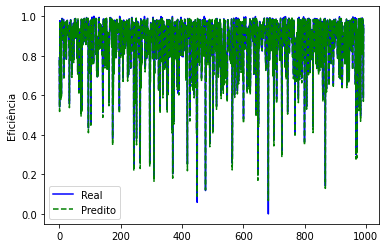

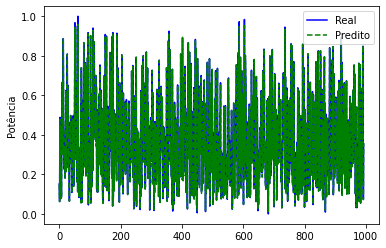

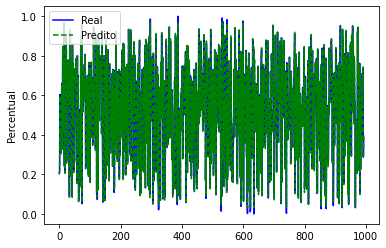

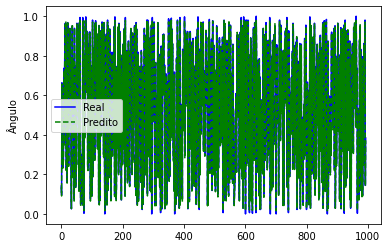



================================= Test ==================================
              Eficiência    Potência  Percentual      Ângulo
        RMSE      0.0076      0.0115      0.0064      0.0094
         MAE      0.0055      0.0088      0.0050      0.0086
          R²      0.9978      0.9972      0.9993      0.9990
Plot results


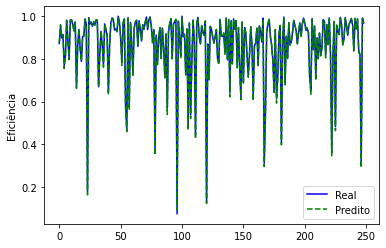

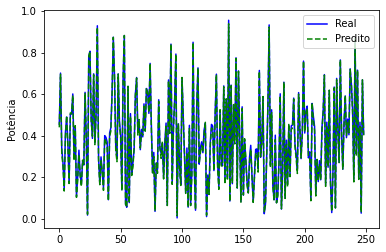

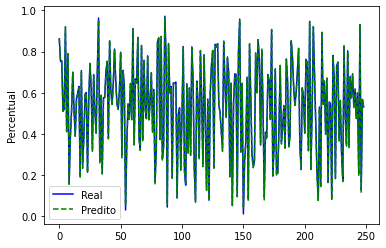

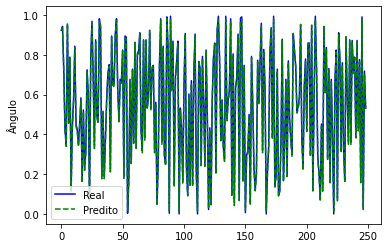

In [ ]:
y1 = model.predict(O_input_train);
y2 = model.predict(O_input_test);

print("================================= Train =================================")
calculateAndPrintEfficience(y1,O_target_train)
plot_grafic(O_target_train,y1)
print("\n")
print("================================= Test ==================================")
calculateAndPrintEfficience(y2,O_target_test)
plot_grafic(O_target_test,y2)

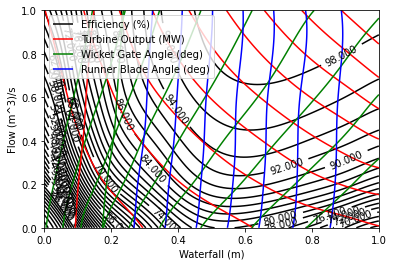

In [ ]:
Points = 100;
Rotation = np.linspace( 0 , 20 , Points )
Flow = np.linspace( 0 , 600 , Points )
[VecRotation,VecFlow] = np.meshgrid(normalize(Rotation),normalize(Flow));

p = np.transpose([VecRotation[:,0],VecFlow[:,0]]);
Hat_Efficiency_2 = [model.predict(p)]
for i in range(1,Points):
  p = np.transpose([VecRotation[:,i],VecFlow[:,i]]);
  Hat_Efficiency_2.append(model.predict(p))
Hat_Efficiency_2 = np.array(Hat_Efficiency_2,dtype=float);

c = plt.contour(VecRotation, VecFlow, (Hat_Efficiency_2[:,:,0]*100), 50, colors='k');
c = plt.clabel(c,colors='black')
c = plt.contour(VecRotation, VecFlow, Hat_Efficiency_2[:,:,1], 10, colors='r');
#plt.clabel(c,colors='red')
c = plt.contour(VecRotation, VecFlow, Hat_Efficiency_2[:,:,2], 10, colors='g');
#plt.clabel(c,colors='green')
c = plt.contour(VecRotation, VecFlow, Hat_Efficiency_2[:,:,3], 10, colors='b');
#plt.clabel(c,colors='blue')

labels = ['Efficiency (%)','Turbine Output (MW)','Wicket Gate Angle (deg)','Runner Blade Angle (deg)'];
color = ['k','r','g','b'];
for i in range(len(labels)):
  c.collections[i].set_label(labels[i]);
  c.collections[i].set_color(color[i]);
plt.legend(loc='upper left');
plt.xlabel('Waterfall (m)');
plt.ylabel('Flow (m^3)/s');